# eCommerce Dataset - EDA and Decision Tree Model
The attached dataset contains website users data (Google Analytics data) from Jan 1, 2017 to Jul 31, 2017. The sample dataset contains obfuscated Google Analytics 360 data from the Google Merchandise Store, a real ecommerce store. The Google Merchandise Store sells Google branded merchandise. The data is typical of what you would see for an ecommerce website. It includes the following kinds of information: 
- Traffic source data: information about where website visitors originate. This includes data about organic traffic, paid search traffic, display traffic, etc.
- Content data: information about the behavior of users on the site.
- Transactional data: information about the transactions that occur on the Google Merchandise Store website.

[Data Source](https://storage.googleapis.com/sample_user_behavior_data/sample_user_data.csv)

[Data Schema](https://support.google.com/analytics/answer/3437719?hl=en)


# Setting up the Environment

Import the necessary packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
from matplotlib.dates import DateFormatter

import time
from datetime import date
from datetime import datetime
from math import log

import pydotplus
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image  


C:\Users\dipik\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Plot settings

In [2]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
sns.set_style("white")
sns.set_palette("muted")

# Load the Dataset
- Read the dataset using read.csv function from pandas
- Review the first five rows of the dataset
- Check the numbber of rows and columns, the datatypes
- Change the column names to suitable column names

In [3]:
input_df = pd.read_csv("C:/Users/dipik/Desktop/Resumes/Merkle Assignment/sample_user_data.csv")
input_df.head()

C:\Users\dipik\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,fullVisitorId,visitNumber,date,visitStartTime,totals_bounces,totals_pageviews,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactions,trafficSource_source,trafficSource_medium,trafficSource_campaign,device_deviceCategory,device_operatingSystem,device_mobileDeviceModel,geoNetwork_city,channelGrouping
0,27376579751715,1,20170211,1486866293,NaN,5.0,49.0,NaN,NaN,(direct),(none),(not set),desktop,Macintosh,not available in demo dataset,not available in demo dataset,Organic Search
1,39460501403861,1,20170327,1490629516,NaN,2.0,99.0,NaN,NaN,youtube.com,referral,(not set),desktop,Windows,not available in demo dataset,not available in demo dataset,Social
2,40862739425590,1,20170211,1486836571,NaN,2.0,14.0,NaN,NaN,(direct),(none),(not set),desktop,Macintosh,not available in demo dataset,Oakland,Paid Search
3,40862739425590,2,20170211,1486838824,NaN,3.0,35.0,NaN,NaN,(direct),(none),(not set),desktop,Macintosh,not available in demo dataset,Oakland,Paid Search
4,62267706107999,1,20170709,1499645960,1.0,1.0,NaN,NaN,NaN,Partners,affiliate,Data Share Promo,desktop,Windows,not available in demo dataset,not available in demo dataset,Affiliates


In [4]:
# Check the number of rows and columns
input_df.shape

(464704, 17)

In [5]:
# Check the datatype
input_df.dtypes

fullVisitorId                      object
visitNumber                         int64
date                                int64
visitStartTime                      int64
totals_bounces                    float64
totals_pageviews                  float64
totals_timeOnSite                 float64
totals_totalTransactionRevenue    float64
totals_transactions               float64
trafficSource_source               object
trafficSource_medium               object
trafficSource_campaign             object
device_deviceCategory              object
device_operatingSystem             object
device_mobileDeviceModel           object
geoNetwork_city                    object
channelGrouping                    object
dtype: object

In [6]:
# Take a back up of the input dataset
input_df_backup = input_df

In [7]:
# change the column names
input_df.rename(index=str, columns={'fullVisitorId': 'Visitor_id',
                              'visitNumber' : 'Visit_Number',
                              'date' : 'Date',
                              'visitStartTime' : 'Visit_StartTime',
                              'totals_bounces' : 'Bounces',
                              'totals_pageviews' : 'Page_Views_Total',
                              'totals_timeOnSite' : 'Time_Per_Session_Total',
                              'totals_totalTransactionRevenue' : 'Transaction_Amt',
                              'totals_transactions' : 'Transactions_Total',
                              'trafficSource_source' : 'Traffic_Source',
                              'trafficSource_medium' : 'Traffic_Source_Medium',
                              'trafficSource_campaign' : 'Traffic_Source_Campaign',
                              'device_deviceCategory' : 'Device_Catg',
                              'device_operatingSystem' : 'OS',
                              'device_mobileDeviceModel' : 'Device_Model',
                              'geoNetwork_city' : 'City',
                              'channelGrouping' : 'Channel'}, inplace=True)

# Data Preprocessing
- Check the columns which have null values
- Replace the null values with zeros or mean based on the column functionality
- Create new columns  
   - Transact : To indicate whether there was a transaction or not (0 - No, 1 - Yes)
   - Month : The month is derived from 'date' column
   - Day : The date is derived from 'date' column
   - Hour : The hour is derived from the Posix VisitStartTime column
   - Transaction_Revenue : The actual transaction amount is derived from TotalTransactionRevenue

In [8]:
# Check for the null values in the dataset
input_df.isnull().sum()

Visitor_id                      0
Visit_Number                    0
Date                            0
Visit_StartTime                 0
Bounces                    232332
Page_Views_Total               52
Time_Per_Session_Total     233021
Transaction_Amt            458396
Transactions_Total         458396
Traffic_Source                  0
Traffic_Source_Medium           0
Traffic_Source_Campaign         0
Device_Catg                     0
OS                              0
Device_Model                    0
City                            0
Channel                         0
dtype: int64

#### Replacing Null Values

- **Total Transaction Revenue & Total Transactions** : Before we replace the null values in Transaction_Amt and Transactions_Total, we need to check if either column value is null when the other has a non-null value. For eg. if Transaction_Amt value is null when Transactions_Total is a non-null value, then we shouldn't replace Transaction_Amt with a zero value
- **Page_Views_Total** : Replace the null value with zero wherever the Time_Per_Session is null/zero. For the remaining null values in the column, you replace it with the mean of the column.
- **Time_Per_Session_Total**: Replace the null value with zero wherever the Bounces = 1. For the remaining null values in the column, you replace it with the mean of the column.
- **Bounces** - Replace the null values in totals_bounces with zero.

In [9]:
# Transaction_Amt and Transactions_Total 
for k in range(0,len(input_df),1):
    if (pd.isna(input_df.iloc[k,7])) and (pd.notna(input_df.iloc[k,8])):
        print('Transaction Revenue missing when Number of Transactions not null at row ', k)

for k in range(0,len(input_df),1):
    if (pd.isna(input_df.iloc[k,8])) and (pd.notna(input_df.iloc[k,7])):
        print('Number of Transactions missing when the Transacation Revenue is not null at row ', k)


In [10]:
# Transaction_Amt and Transactions_Total 
input_df['Transaction_Amt'].fillna(0, inplace=True)
input_df['Transactions_Total'].fillna(0, inplace=True)

In [11]:
# Page Views 
for k in range(0,len(input_df),1):
    if (pd.isna(input_df.iloc[k,5])) and (pd.isna(input_df.iloc[k,6])):
        input_df.iloc[k,5] = 0
        
input_df['Page_Views_Total'] = input_df['Page_Views_Total'].fillna((input_df['Page_Views_Total'].mean()))

In [12]:
# Time_Per_Session_Total
for k in range(0,len(input_df),1):
    if (pd.isna(input_df.iloc[k,6])) and (pd.notna(input_df.iloc[k,4])):
        input_df.iloc[k,6] = 0
input_df['Time_Per_Session_Total'] = input_df['Time_Per_Session_Total'].fillna((input_df['Time_Per_Session_Total'].mean()))

In [13]:
# Bounces
input_df['Bounces'].fillna(0, inplace=True)

In [14]:
# Check if all the null values have been addressed
input_df.isnull().sum()

Visitor_id                 0
Visit_Number               0
Date                       0
Visit_StartTime            0
Bounces                    0
Page_Views_Total           0
Time_Per_Session_Total     0
Transaction_Amt            0
Transactions_Total         0
Traffic_Source             0
Traffic_Source_Medium      0
Traffic_Source_Campaign    0
Device_Catg                0
OS                         0
Device_Model               0
City                       0
Channel                    0
dtype: int64

#### Create new column to indicate whether customer transacted or not

In [15]:
#Transact : To indicate whether there was a transaction or not (0 - No, 1 - Yes)

input_df['transact'] = np.where(input_df['Transactions_Total']  == 0, '0','1')
input_df['transact'] = input_df['transact'].astype('str')

In [16]:
#Visitor ID : Convert it to string type

input_df['Visitor_id'] = input_df['Visitor_id'].astype('str')

In [17]:
#Month: The month is derived from 'Date' column 
#Day : The date is derived from 'Date' column

# Create two new columns for month and day
input_df[['month']] = input_df[['Date']].applymap(str).applymap(lambda s: "{}".format(s[4:6]))
input_df[['day']] = input_df[['Date']].applymap(str).applymap(lambda s: "{}".format(s[6:]))
input_df['month'] = input_df['month'].astype('str')
input_df['day'] = input_df['day'].astype('str')

In [18]:
#Hour : The hour is derived from the Posix VisitStartTime column

input_df['fr_posix'] = pd.to_datetime(input_df['Visit_StartTime'],unit='s')
input_df[['hour']] = input_df[['fr_posix']].applymap(str).applymap(lambda s: "{}".format(s[11:13]))

In [19]:
#Transaction_Revenue : The actual transaction amount is derived from TotalTransactionRevenue

input_df['Transaction_Revenue'] = input_df['Transaction_Amt'] / 1000000

# Create the final dataset for EDA 

The following columns are dropped from the input dataset
- Date : The month and day has been extracted from this. There is no value in reviewing the year since we have information only for a year.
- Visit_StartTime : The hour has been extracted from this. There is no value in reviewing the minutes, seconds for the EDA and modelling
- Device_Model : This information is not available in the demo dataset.
- fr_posix : This was a temp variable created to extract the time from the POSIX time.
- Transaction_Amt : The actual Transaction Amount is generated and used for EDA and modelling

In [20]:
final_df = input_df.drop(['Date','Visit_StartTime','Device_Model','fr_posix','Transaction_Amt'],axis=1)

In [21]:
final_df.head()

,Visitor_id,Visit_Number,Bounces,Page_Views_Total,Time_Per_Session_Total,Transactions_Total,Traffic_Source,Traffic_Source_Medium,Traffic_Source_Campaign,Device_Catg,OS,City,Channel,transact,month,day,hour,Transaction_Revenue
0,27376579751715,1,0.0,5.0,49.0,0.0,(direct),(none),(not set),desktop,Macintosh,not available in demo dataset,Organic Search,0,02,11,02,0.0
1,39460501403861,1,0.0,2.0,99.0,0.0,youtube.com,referral,(not set),desktop,Windows,not available in demo dataset,Social,0,03,27,15,0.0
2,40862739425590,1,0.0,2.0,14.0,0.0,(direct),(none),(not set),desktop,Macintosh,Oakland,Paid Search,0,02,11,18,0.0
3,40862739425590,2,0.0,3.0,35.0,0.0,(direct),(none),(not set),desktop,Macintosh,Oakland,Paid Search,0,02,11,18,0.0
4,62267706107999,1,1.0,1.0,0.0,0.0,Partners,affiliate,Data Share Promo,desktop,Windows,not available in demo dataset,Affiliates,0,07,09,00,0.0


# Exploratory Data Analysis


#### Summary
From the below summary, you can see there are outliers in the dataset.
- **Visit_Number** - The average number of times that a visitor has visited the ecommerce site is around 2. Given that 75% of the visitors visited just once, you can detect there are outliers in the value with the maximum value of 395 times.
- **Bounces** - More than 50% of the visits resulted in a bounce as per the below summary. 
- **Page_Views_Total** - The average number of times that the page has been viewed is close to 4 times. Given that 75% of the visits resulted in average 4 views, you can see that there is an outlier where the maximum value is 466 times!
- **Transactions_Total**- The average number of transactions per visit is very low at 0.014. As you can see for more than 75% of the customers the number of transactions is zero. Clearly there are outliers, with the max value being at 25.
- **Transaction_Revenue** - The average amount of transaction revenue generated per visit is 2 dollars. This does not seem correct. We can see an outlier with the value of 47082 dollars. This could be the reason that the average is at 2 dollars. If we remove the outlier, then the average transaction revenue generated per visit could be much lower. 


From the box plots for Transactions_Total and Transaction_Revenue, you can clearly see there are outliers which should be reviewed closely.

In [22]:
final_df.describe()

,Visit_Number,Bounces,Page_Views_Total,Time_Per_Session_Total,Transactions_Total,Transaction_Revenue
count,464704.000000,464704.000000,464704.000000,464704.000000,464704.000000,464704.000000
mean,2.333767,0.500043,3.770307,139.729842,0.014205,2.195026
std,9.877242,0.500001,6.401766,374.650310,0.136001,106.906946
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,4.000000,95.000000,0.000000,0.000000
max,395.000000,1.000000,466.000000,12136.000000,25.000000,47082.060000


In [23]:
final_df['transact'].value_counts()

0    458396
1      6308
Name: transact, dtype: int64

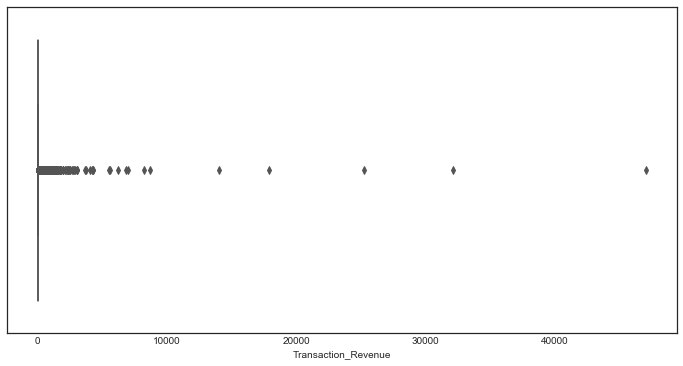

In [24]:
ax = sns.boxplot(x=final_df["Transaction_Revenue"])

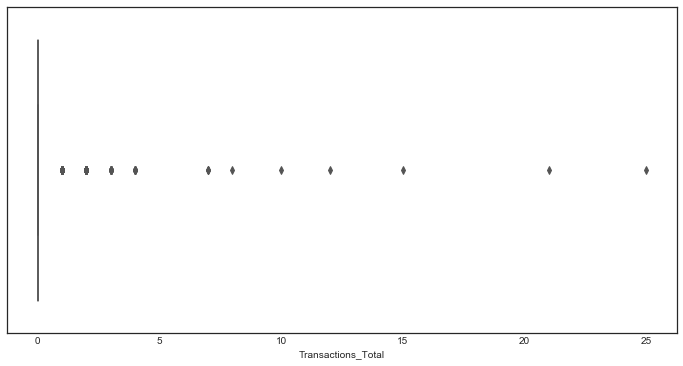

In [25]:
ax = sns.boxplot(x=final_df["Transactions_Total"])

**Plot for the number of transactions by month**

From the plot you can see that there isn't a lot of variation in the number of transactions completed per month. 

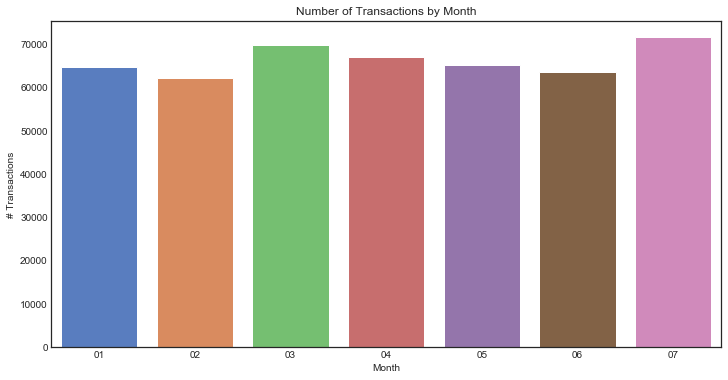

In [26]:
plot=sns.countplot(x='month', data=final_df[~final_df['transact'].str.startswith(('C'))])
plt.xlabel("Month")
plt.ylabel("# Transactions")
plt.title("Number of Transactions by Month")
plt.show(plot)

**Plot for the number of transactions by date**

From the plot you can see that there is a dip in the number of transactions towards the end of the month. This could be show that the visitors are more cautious about spending towards the end of the month.

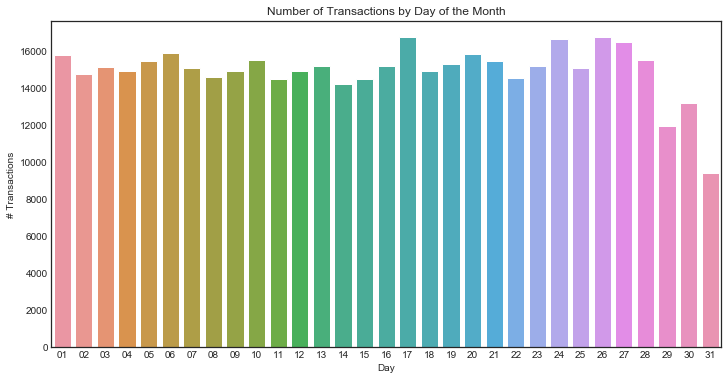

In [27]:
plot=sns.countplot(x='day', data=final_df[~final_df['transact'].str.startswith(('C'))])
plt.xlabel("Day")
plt.ylabel("# Transactions")
plt.title("Number of Transactions by Day of the Month")
plt.show(plot)

**Plot for the number of transactions by hour**

The graph clearly shows an increase in the number of transactions from mid-afternoon or post 15:00. The number of transactions peak during the evening and continue to fall during the night. As would be expected, the number of transactions are lowest in the early hours of the morning. The presence of the transactions during the early hours could also indicate that the site is accessed in other timezones where probably it is not the early morning hours

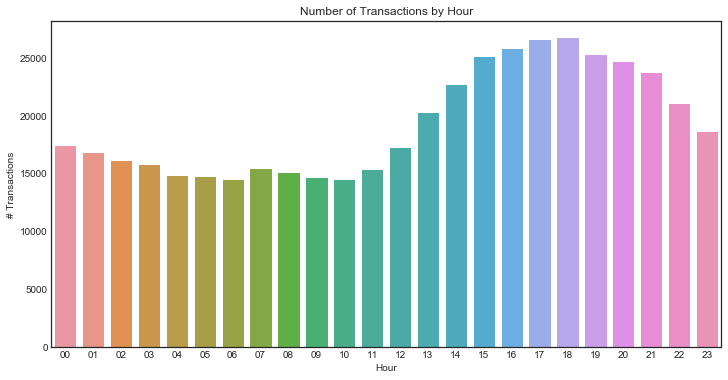

In [28]:
plot=sns.countplot(x='hour', data=final_df[~final_df['transact'].str.startswith(('C'))])
plt.xlabel("Hour")
plt.ylabel("# Transactions")
plt.title("Number of Transactions by Hour")
plt.show(plot)

**Plot for the number of transactions by number of page views**

From the plot you can see that there are outliers and that most of the transactions happen when the number of page views is less than 25. 

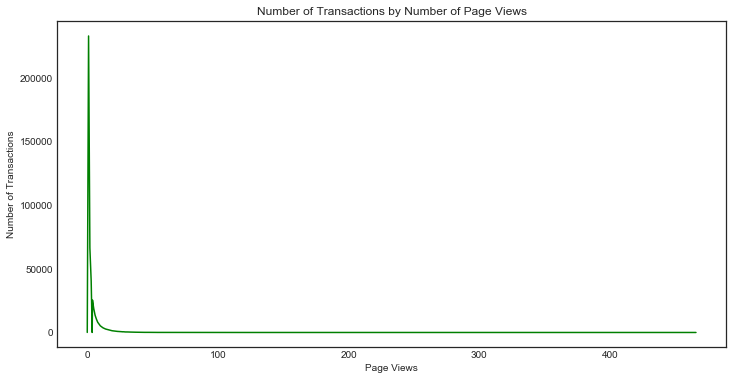

In [29]:
temp_file = final_df.groupby(by=['Page_Views_Total'], as_index=False)['transact'].count()
plt.plot(temp_file.Page_Views_Total, temp_file.transact,color='green')
plt.xlabel('Page Views')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Number of Page Views')
plt.show()

**Plot for the number of transactions by time spent per session**

From the plot you can see that there are outliers and that most of the transactions happen when the time per session is less than 200

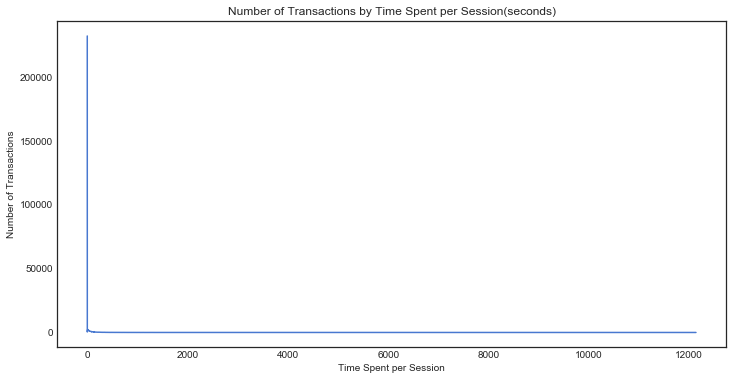

In [30]:
temp_file = final_df.groupby(by=['Time_Per_Session_Total'], as_index=False)['transact'].count()
plt.plot(temp_file.Time_Per_Session_Total, temp_file.transact)
plt.xlabel('Time Spent per Session')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Time Spent per Session(seconds)')
plt.show()  

**Plot for the number of transactions by Device**

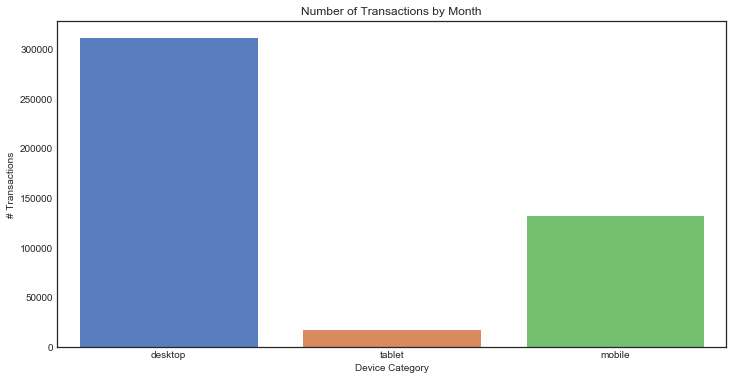

In [31]:
plot = sns.countplot(x='Device_Catg', data=final_df[~final_df['transact'].str.startswith(('C'))])
plt.xlabel("Device Category")
plt.ylabel("# Transactions")
plt.title("Number of Transactions by Month")
plt.show(plot)

**Plot for the number of transactions by the Top Ten Cities**

There are a lot of missing values for the City given by 'not available in demo dataset' or '(not set)'. These can be removed and we can generate this list of top ten cities by transaction numbers again

There are 436 unique cities in the dataset. Top 10 cities are:
City
not available in demo dataset    222985
(not set)                         13483
Mountain View                     12654
New York                           9649
San Francisco                      7677
London                             5987
Sunnyvale                          4732
San Jose                           3769
Los Angeles                        3716
Bengaluru                          2705
Name: Visitor_id, dtype: int64

The top 10 cities covers 61.8 percent of all the orders.


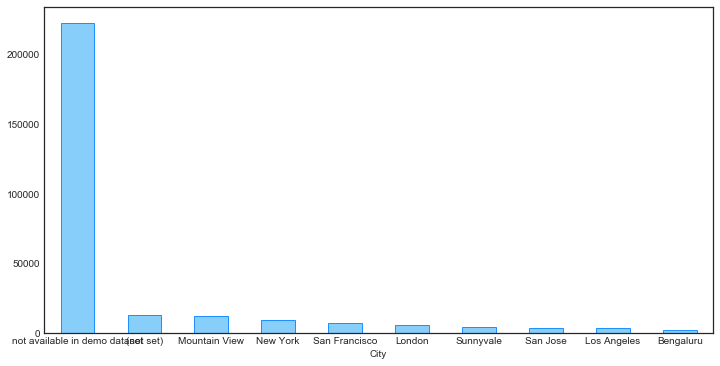

In [32]:
cities = final_df["City"].nunique()
city1 = final_df.groupby('City')['Visitor_id'].nunique().sort_values(ascending=False)
print("There are",cities,"unique cities in the dataset. Top 10 cities are:")
city2 = city1.head(10)
print(city2)
print("\nThe top 10 cities covers", round(city2.sum()/final_df.shape[0]*100,1),"percent of all the orders.")
city2.plot(kind="bar",rot=0,edgecolor='dodgerblue', color='lightskyblue')

**Plot for the number of transactions by the Top Ten Traffic Sources**


There are 223 unique traffic sources in the dataset. Top 10 sources are:
Traffic_Source
google                  148210
(direct)                142826
youtube.com              47077
analytics.google.com      8286
Partners                  7884
google.com                2598
m.facebook.com            2594
dfa                       1665
reddit.com                1175
t.co                      1080
Name: Visitor_id, dtype: int64

The top 10 traffice sources covers 78.2 percent of all the orders.


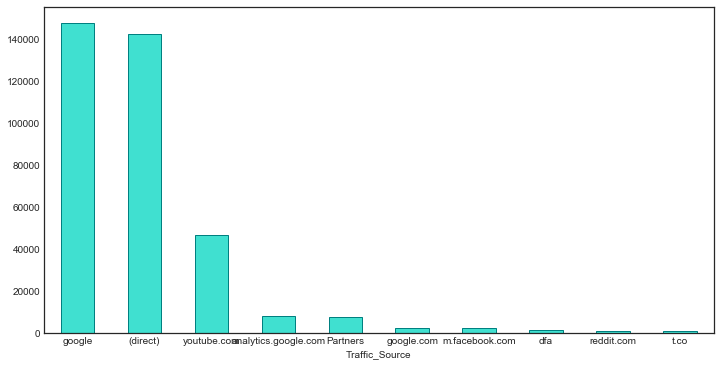

In [33]:
sources = final_df["Traffic_Source"].nunique()
source1 = final_df.groupby('Traffic_Source')['Visitor_id'].nunique().sort_values(ascending=False)
print("There are",sources,"unique traffic sources in the dataset. Top 10 sources are:")
source2 = source1.head(10)
print(source2)
print("\nThe top 10 traffice sources covers", round(source2.sum()/final_df.shape[0]*100,1),"percent of all the orders.")
source2.plot(kind="bar",rot=0,edgecolor='teal', color='turquoise')

**Plot for the number of transactions by the Top Ten Source Medium**


There are 7 unique traffic mediums in the dataset
Traffic_Source_Medium
organic      145177
(none)       142824
referral      72318
affiliate      7881
cpc            6987
cpm            2047
(not set)        84
Name: Visitor_id, dtype: int64


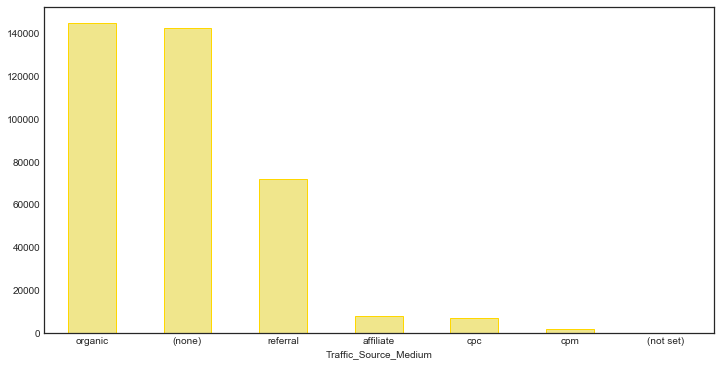

In [34]:
mediums = final_df["Traffic_Source_Medium"].nunique()
medium1 = final_df.groupby('Traffic_Source_Medium')['Visitor_id'].nunique().sort_values(ascending=False)
print("There are",mediums,"unique traffic mediums in the dataset")
medium2 = medium1.head(10)
print(medium2)
medium2.plot(kind="bar",rot=0,edgecolor='gold', color='khaki')


**Plot for the number of transactions by the Top Ten Campaigns**

There are a lot of missing values for the Campaign given by '(not set)'. These can be removed and we can generate this list of top ten cities by transaction numbers again

There are 7 unique campaigns in the dataset
Traffic_Source_Campaign
(not set)                             351762
Data Share Promo                        7880
AW - Accessories                        4036
AW - Dynamic Search Ads Whole Site      2395
AW - Apparel                              28
AW - Electronics                           3
Data Share                                 1
Name: Visitor_id, dtype: int64


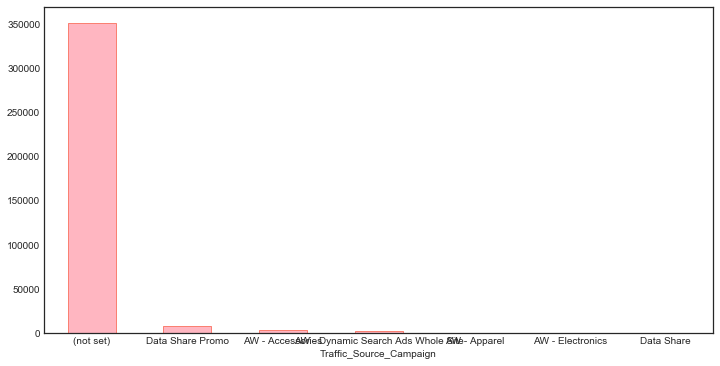

In [35]:
mediums = final_df["Traffic_Source_Campaign"].nunique()
medium1 = final_df.groupby('Traffic_Source_Campaign')['Visitor_id'].nunique().sort_values(ascending=False)
print("There are",mediums,"unique campaigns in the dataset")
medium2 = medium1.head(10)
print(medium2)
medium2.plot(kind="bar",rot=0,edgecolor='salmon', color='lightpink')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

**Plot for the number of transactions by the Top Ten Channels**

There are 8 unique channels in the dataset
Channel
Organic Search    193066
Direct             68101
Social             55288
Referral           38194
Paid Search        10618
Affiliates          7881
Display             2093
(Other)               84
Name: Visitor_id, dtype: int64


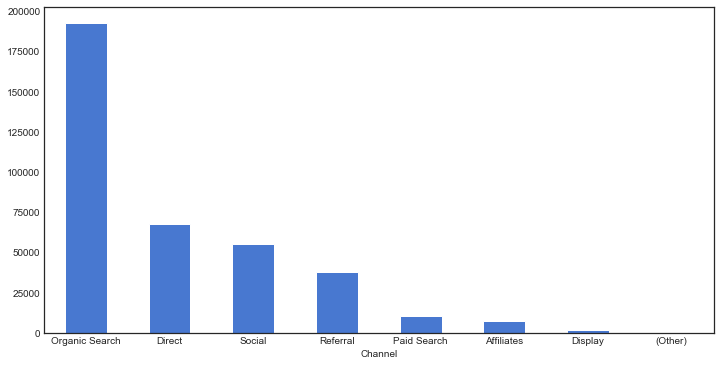

In [36]:
mediums = final_df["Channel"].nunique()
medium1 = final_df.groupby('Channel')['Visitor_id'].nunique().sort_values(ascending=False)
print("There are",mediums,"unique channels in the dataset")
medium2 = medium1.head(10)
print(medium2)
medium2.plot(kind="bar",rot=0)

In [41]:
temp_df = final_df.groupby(by=['Visitor_id','City'], as_index=False)['Transaction_Revenue'].sum()
temp_df.sort_values(by='Transaction_Revenue',ascending=False).head()

,Visitor_id,City,Transaction_Revenue
39238,1957458976293878100,not available in demo dataset,128412.52
344049,9417857471295131045,not available in demo dataset,41810.85
141774,4471415710206918415,Mountain View,10465.10
328025,9026840718082010040,not available in demo dataset,9011.18
282767,79204932396995037,not available in demo dataset,7056.15


In [ ]:
plt.subplots(figsize=(15,6))
plt.plot(temp_df.Visitor_id, temp_df.Transaction_Revenue)
plt.xlabel('Visitor ID')
plt.ylabel('Revenue Generated ($)')
plt.title('Revenue Generated by Visitors')
plt.show()

In [39]:
temp_df = final_df.groupby(by=['Visitor_id','City'], as_index=False)['Transactions_Total'].sum()
temp_df.sort_values(by='Transactions_Total', ascending=False).head()

,Visitor_id,City,Transactions_Total
278419,7813149961404844386,Salem,27.0
184884,5526675926038480325,New York,25.0
39238,1957458976293878100,not available in demo dataset,22.0
162755,4983264713224875783,not available in demo dataset,21.0
312126,8637158932301658318,San Jose,15.0


In [ ]:
plt.subplots(figsize=(15,6))
plt.plot(temp_df.Visitor_id, temp_df.Transactions_Total)
plt.xlabel('Visitor ID')
plt.ylabel('Number of Transactions')
plt.title('Transactions performed by Visitors')
plt.show()

In [44]:
final_df.dtypes

Visitor_id                   int32
Visit_Number                 int64
Bounces                    float64
Page_Views_Total           float64
Time_Per_Session_Total     float64
Transactions_Total         float64
Traffic_Source               int32
Traffic_Source_Medium        int32
Traffic_Source_Campaign      int32
Device_Catg                  int32
OS                           int32
City                         int32
Channel                      int32
transact                    object
month                       object
day                         object
hour                        object
Transaction_Revenue        float64
dtype: object

In [45]:
#To convert categorical variables to integer using label encoder
LabelEnc = LabelEncoder()
cat_columns = ['Visitor_id','Traffic_Source','Traffic_Source_Medium','Traffic_Source_Campaign','Device_Catg',
              'OS','City','Channel','transact','month','day','hour']

for col in cat_columns:
    final_df[col]=LabelEnc.fit_transform(final_df[col])  

#### Correlation Matrix between all the features and transact
As you can see from the below correlation matrix, 
- the target variable 'transact' is positively correlated with the number of pages viewed in the session (Page_Views_Total) and the time spent per session (Time_Per_Session_Total). This is apart from being positively correlated with the Transactions_Total and Transaction_Revenue, which it obviously will be correlated to.
- the target variable 'transact' is negatively correlated with the Bounces, Traffic_Source, Traffic_Medium and the Device_Category.

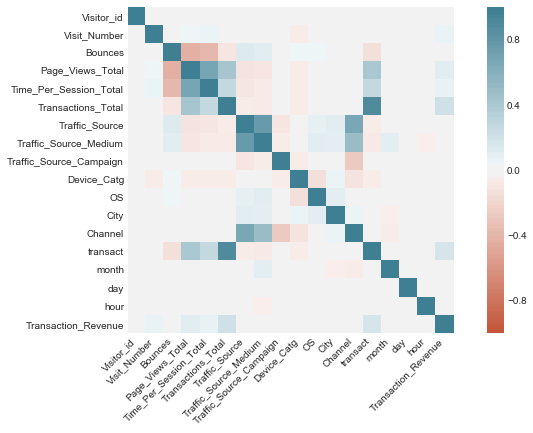

In [46]:
corr = final_df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Splitting the Dataset into Test and Train

In [47]:
#split dataset in features and target variable
feature_cols = ['Visitor_id', 'Visit_Number', 'Bounces','Page_Views_Total','Time_Per_Session_Total',
                'Traffic_Source','Traffic_Source_Medium','Traffic_Source_Campaign','Device_Catg',
                'OS','City','Channel','day','month','hour']

#features
X = final_df[feature_cols] 

#Target variable
y = final_df.transact 

In [51]:
# Split dataset into training set(80%) and test set(20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42,stratify=y) 

# Decision Tree Model

In [52]:
# Create Decision Tree classifer model
transact_classifier = DecisionTreeClassifier()

# Train Decision Tree Classifer model
transact_classifier = transact_classifier.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = transact_classifier.predict(X_test)

# Model Metrics

- Using the following features, we are able to achieve an accuracy of 98%.
    - Visitor_id 
    - Visit_Number
    - Bounces 
    - Page_Views_Total 
    - Time_Per_Session_Total
    - Traffic_Source 
    - Traffic_Source_Medium 
    - Traffic_Source_Campaign 
    - Device_Catg 
    - OS 
    - City 
    - Channel 
    - day 
    - month 
    - hour 


- You can see from the confusion matrix, that the model is able to predict True Positive for 317422 observations and a True Negative for 1428 observations. The number of False Positive and False Negative observations are 2988 and 3455 respectively. 


- We have a high value for Recall, indicating the classes are correctly identified


- We have a high value for Precision, indicating the positive class is correctly identified for most observations.


- From feature importance dictionary, you can see the top five features which affect the classification are 
  - Page_Views_Total (26%)
  - Visitor_Id (15%)
  - Time_Per_Session_Total (13%)
  - Day (8%)
  - Hour (8%)

In [53]:
# Model metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9801932411702681


In [54]:
confusion_matrix(y_test,y_pred)

array([[317422,   3455],
       [  2988,   1428]], dtype=int64)

In [63]:
print('Recall = ',(317422/(317422+3455)))

Recall =  0.9892326343115898


In [67]:
print('Precision = ',(317422/(317422+2988)))

Precision =  0.9906744483630349


In [62]:
feat_impt_dict = dict(zip(X_train.columns, transact_classifier.feature_importances_))
for key,val in feat_impt_dict.items():
    print(key, "=>", val)

Visitor_id => 0.15078698726307369
Visit_Number => 0.06511860235500853
Bounces => 0.0
Page_Views_Total => 0.2643213812420625
Time_Per_Session_Total => 0.13169501205432624
Traffic_Source => 0.012332581778215267
Traffic_Source_Medium => 0.014652129253783806
Traffic_Source_Campaign => 0.0030342380247639833
Device_Catg => 0.012876064744415576
OS => 0.034560856156037836
City => 0.07069778737351715
Channel => 0.027377279767181465
day => 0.08768613325393693
month => 0.045457079455157555
hour => 0.07940386727851936


# Visualization - Decision Tree

In [55]:
dot_data = StringIO()
export_graphviz(transact_classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

In [ ]:
Image(graph.create_png())